# Modélisation du risque de crédit et méthodes de scoring  
**Université de Nantes — IAE Nantes**  
**Année universitaire 2024–2025**

**Étudiants :** *CADET Timothée, DAËRON Djayan, HOUSSAIS Rémi*  
**Enseignant :** *[WAFO FOUEKA Serge]*  

---

## Introduction

L’évaluation du risque de crédit constitue un enjeu central pour les établissements financiers, tant pour sécuriser leurs portefeuilles que pour optimiser leurs décisions d’octroi. Dans ce projet, nous analysons un ensemble de données réelles afin de construire différents modèles de scoring permettant de prédire la probabilité de défaut d’un client.

L’objectif du travail est triple :  
1. **Préparer et structurer** les données grâce à une analyse exploratoire rigoureuse.  
2. **Construire et comparer plusieurs modèles**, allant des approches économétriques classiques (Logit, Probit) aux méthodes modernes de machine learning (arbres, forêts aléatoires, boosting…).  
3. **Interpréter les résultats** afin d’identifier les déterminants du risque de crédit et proposer une méthode de scoring performante et explicable.

Ce rapport présente successivement la préparation des données, le choix des méthodes d'encodage, les modèles retenus et leur évaluation.



## 1. Étapes préliminaires

### 1.1. Importer la base de données

In [ ]:
# Importer la base de donées 

import pandas as pd


# Charger un fichier SAS (.sas7bdat)

df = pd.read_sas("../data/raw/credit.sas7bdat", format="sas7bdat", encoding="latin1")


# Afficher les premières lignes

print(df.head())

### 1.2. Vérifier la nature des variables et effectuer les transformations nécessaires


In [ ]:
# Nature des variables

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cle                  994 non-null    category
 1   Comptes              994 non-null    category
 2   Duree_credit         994 non-null    float64 
 3   Historique_credit    994 non-null    category
 4   Objet_credit         994 non-null    category
 5   Montant_credit       994 non-null    float64 
 6   Epargne              994 non-null    category
 7   Anciennete_emploi    994 non-null    category
 8   Taux_effort          994 non-null    category
 9   Situation_familiale  994 non-null    category
 10  Garanties            994 non-null    category
 11  Anciennete_domicile  994 non-null    category
 12  Biens                994 non-null    category
 13  Age                  994 non-null    float64 
 14  Autres_credits       994 non-null    category
 15  Statut_domicile      994 non

In [87]:
# Transformer les types

# Définir les colonnes numériques
num_cols = ["Age", "Duree_credit", "Montant_credit"]

# Boucle sur toutes les colonnes
for col in df.columns:
    if col not in num_cols:
        # Convertir seulement si ce n'est pas dans num_cols
        df[col] = df[col].astype('category')
    else:
        # S'assurer que les colonnes numériques sont bien float
        df[col] = df[col].astype('float64')

# Vérification
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cle                  994 non-null    category
 1   Comptes              994 non-null    category
 2   Duree_credit         994 non-null    float64 
 3   Historique_credit    994 non-null    category
 4   Objet_credit         994 non-null    category
 5   Montant_credit       994 non-null    float64 
 6   Epargne              994 non-null    category
 7   Anciennete_emploi    994 non-null    category
 8   Taux_effort          994 non-null    category
 9   Situation_familiale  994 non-null    category
 10  Garanties            994 non-null    category
 11  Anciennete_domicile  994 non-null    category
 12  Biens                994 non-null    category
 13  Age                  994 non-null    float64 
 14  Autres_credits       994 non-null    category
 15  Statut_domicile      994 non

In [89]:
# Recoder la variable Cible en 0 et 1
df['Cible'] = df['Cible'].map({1: 0, 2: 1})

## 2. Analyse exploratoire et préparation des données

In [57]:
#Analyse des valeurs manquantes
df.isnull().sum() #pas de valeurs manquantes

Cle                    0
Comptes                0
Duree_credit           0
Historique_credit      0
Objet_credit           0
Montant_credit         0
Epargne                0
Anciennete_emploi      0
Taux_effort            0
Situation_familiale    0
Garanties              0
Anciennete_domicile    0
Biens                  0
Age                    0
Autres_credits         0
Statut_domicile        0
Nb_credits             0
Type_emploi            0
Nb_pers_charge         0
Telephone              0
Cible                  0
dtype: int64

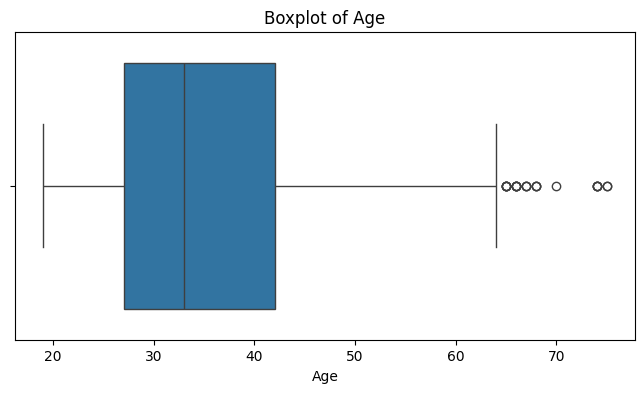

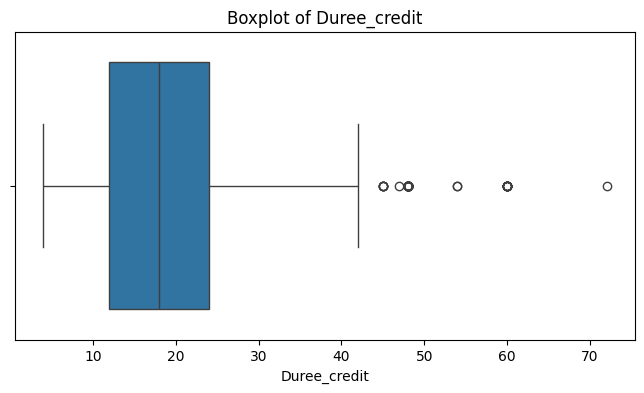

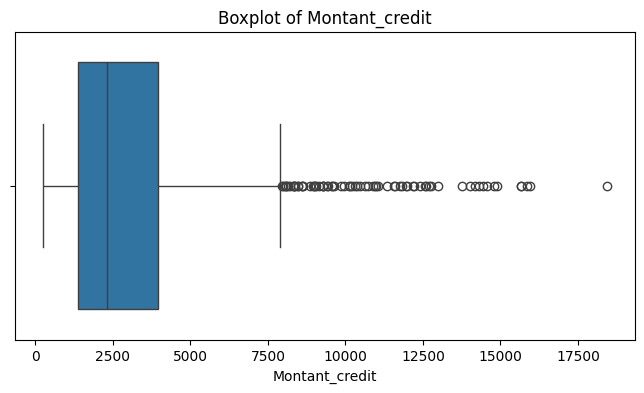

In [58]:
#Analyse des outliers

numeric_cols = ['Age', 'Duree_credit', 'Montant_credit']

import matplotlib.pyplot as plt
import seaborn as sns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [59]:
# Vérifier la présence d'outliers sur les variables

# Duree_credit
from scikit_posthocs import outliers_gesd
no_outlier = outliers_gesd(df["Duree_credit"], alpha=0.05, hypo=False)
len(no_outlier) # 1 outliers
df = df[df["Duree_credit"] != df["Duree_credit"].max()]

In [60]:
# Montant_credit
no_outlier = outliers_gesd(df["Montant_credit"], alpha=0.05, hypo=False)
len(no_outlier) # 5 outliers
df = df.drop(df.nlargest(5, "Montant_credit").index)


In [61]:
#Age
no_outlier = outliers_gesd(df["Age"], alpha=0.05, hypo=False)
len(no_outlier) # pas outliers

994

On a enlevé 6 observations atypiques sur l'ensemble de nos variables quantitatives

In [62]:
df.shape

(994, 21)

### Transformer les données

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cle                  994 non-null    category
 1   Comptes              994 non-null    category
 2   Duree_credit         994 non-null    float64 
 3   Historique_credit    994 non-null    category
 4   Objet_credit         994 non-null    category
 5   Montant_credit       994 non-null    float64 
 6   Epargne              994 non-null    category
 7   Anciennete_emploi    994 non-null    category
 8   Taux_effort          994 non-null    category
 9   Situation_familiale  994 non-null    category
 10  Garanties            994 non-null    category
 11  Anciennete_domicile  994 non-null    category
 12  Biens                994 non-null    category
 13  Age                  994 non-null    float64 
 14  Autres_credits       994 non-null    category
 15  Statut_domicile      994 non

Pour préparer le jeu de données à l'analyse et à la modélisation, les colonnes ont été séparées en **numériques** et **catégorielles** :

- Les colonnes `"Age"`, `"Duree_credit"` et `"Montant_credit"` sont conservées comme **numériques** (`float64`) car elles sont continues et permettent d'effectuer des calculs statistiques et d'alimenter directement les modèles linéaires.

- Toutes les autres colonnes ont été converties en **catégorielles** (`category`). Certaines de ces colonnes peuvent sembler numériques mais elles sont en réalité **discrètes** et représentent des catégories (par exemple : `Nb_credits`, `Anciennete_emploi`). Les raisons principales de cette conversion sont :
  1. **Respect de la nature des données** : les valeurs représentent des catégories et non des quantités continues, donc les traiter comme numériques pourrait induire en erreur l'interprétation ou le modèle.
  2. **Optimisation mémoire** : les colonnes catégorielles utilisent moins de mémoire que les colonnes numériques.
  3. **Préparation pour les modèles** : les modèles comme Logistic Regression, Random Forest ou CatBoost gèrent mieux les variables catégorielles via One-Hot Encoding ou encodage interne, ce qui permet une meilleure performance et interprétation.

Cette transformation assure que chaque variable est traitée selon sa nature réelle et prépare le dataset pour les étapes suivantes de modélisation statistique et machine learning.


### Statistiques descriptives univariées

In [64]:
# Statistiques descriptives univariées numériques 

num_stats = df[num_cols].describe().T
num_stats['variance'] = df[num_cols].var()
num_stats['skewness'] = df[num_cols].skew()
num_stats['kurtosis'] = df[num_cols].kurt()
num_stats['missing'] = df[num_cols].isna().sum()

print(num_stats)


                count         mean          std    min     25%     50%  \
Age             994.0    35.558350    11.362254   19.0    27.0    33.0   
Duree_credit    994.0    20.709256    11.801521    4.0    12.0    18.0   
Montant_credit  994.0  3203.331992  2672.860398  250.0  1364.0  2302.5   

                   75%      max      variance  skewness  kurtosis  missing  
Age               42.0     75.0  1.291008e+02  1.023731  0.609106        0  
Duree_credit      24.0     60.0  1.392759e+02  1.056352  0.767984        0  
Montant_credit  3956.5  14896.0  7.144183e+06  1.788120  3.313785        0  


Après suppression des valeurs atypiques, les variables numériques `"Age"`, `"Duree_credit"` et `"Montant_credit"` ont été analysées pour mieux refléter la population typique des clients.

- **Age** : moyenne ≈ 35 ans, médiane = 33 ans, distribution légèrement asymétrique vers les âges plus élevés (skew ≈ 1.03).

- **Durée du crédit** : moyenne ≈ 20.7 mois, médiane = 18 mois, légère asymétrie positive (skew ≈ 1.06). Les valeurs extrêmes ont été éliminées, facilitant l'analyse des durées typiques.

- **Montant du crédit** : moyenne ≈ 3204.5, médiane = 2302.5, distribution toujours légèrement asymétrique (skew ≈ 1.79) mais sans les très gros crédits qui pouvaient fausser les statistiques.

**Intérêt** :  
1. Fournir une vision plus réaliste et représentative de la population typique.  
2. Faciliter l’analyse et la modélisation en réduisant l’influence des valeurs extrêmes.  
3. Permettre des comparaisons et interprétations fiables lors de la modélisation statistique ou machine learning.


In [65]:
# Sélectionner les colonnes catégorielles
cat_cols = df.select_dtypes(include='category').columns
cat_cols = cat_cols.drop('Cle')

# Statistiques de base pour chaque catégorie

for col in cat_cols:
    print(f"=== {col} ===")
    print(df[col].value_counts(dropna=False))   # fréquence de chaque modalité
    print(df[col].value_counts(normalize=True)) # pourcentage
    print("\n")


=== Comptes ===
Comptes
4.0    393
1.0    273
2.0    265
3.0     63
Name: count, dtype: int64
Comptes
4.0    0.395372
1.0    0.274648
2.0    0.266600
3.0    0.063380
Name: proportion, dtype: float64


=== Historique_credit ===
Historique_credit
A32    527
A34    293
A33     87
A31     49
A30     38
Name: count, dtype: int64
Historique_credit
A32    0.530181
A34    0.294769
A33    0.087525
A31    0.049296
A30    0.038229
Name: proportion, dtype: float64


=== Objet_credit ===
Objet_credit
A43    278
A40    234
A42    181
A41    113
A49     95
A46     50
A45     22
A44     12
A48      9
Name: count, dtype: int64
Objet_credit
A43    0.279678
A40    0.235412
A42    0.182093
A41    0.113682
A49    0.095573
A46    0.050302
A45    0.022133
A44    0.012072
A48    0.009054
Name: proportion, dtype: float64


=== Epargne ===
Epargne
1.0    598
0.0    183
2.0    102
3.0     63
4.0     48
Name: count, dtype: int64
Epargne
1.0    0.601610
0.0    0.184105
2.0    0.102616
3.0    0.063380
4.0    0.0482

Pour chaque variable catégorielle, le tableau ci-dessus présente le **nombre d’occurrences (count)** et la **proportion** de chaque modalité dans le dataset.  

Quelques observations clés :  

- **Comptes** : La plupart des clients ont 4 comptes (≈ 40%), tandis que très peu ont 3 comptes (≈ 6%).  
- **Historique_credit** : La majorité des clients sont classés A32 (≈ 53%), ce qui correspond à un bon historique de crédit.  
- **Objet_credit** : Les crédits A43, A40 et A42 représentent la majorité des demandes (≈ 70%), montrant une concentration sur certains types de crédits.  
- **Epargne** : 60% des clients ont un niveau d’épargne codé "1", peu ont un niveau élevé.  
- **Anciennete_emploi** : La majorité des clients sont employés depuis 3 à 5 ans.  
- **Taux_effort** : Les clients sont majoritairement dans la tranche 4 (≈ 48%), représentant un effort financier plus élevé.  
- **Garanties** : La quasi-totalité des clients (≈ 91%) possède la garantie A101.  
- **Nb_credits** et **Nb_pers_charge** : Très déséquilibrés, la majorité des clients n’a qu’un seul crédit et une seule personne à charge.  
- **Cible** : Le dataset est déséquilibré, avec ≈ 70% de clients non-défaillants (0) et ≈ 30% de clients défaillants (1).

**Intérêt** :  
1. Identifier les modalités dominantes et minoritaires dans chaque variable.  
2. Détecter d’éventuels déséquilibres ou biais dans les données, ce qui est important pour la modélisation (ex. certaines catégories très peu représentées peuvent nécessiter un regroupement).  
3. Comprendre la distribution des caractéristiques des clients pour mieux interpréter les modèles statistiques et machine learning.


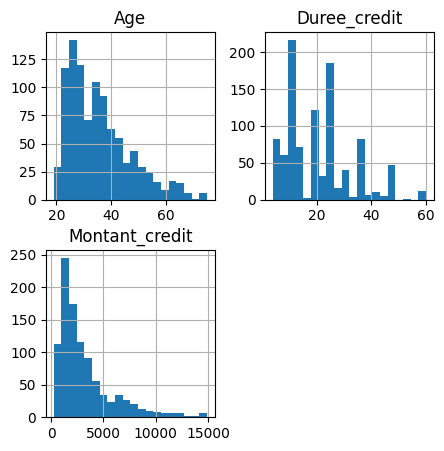

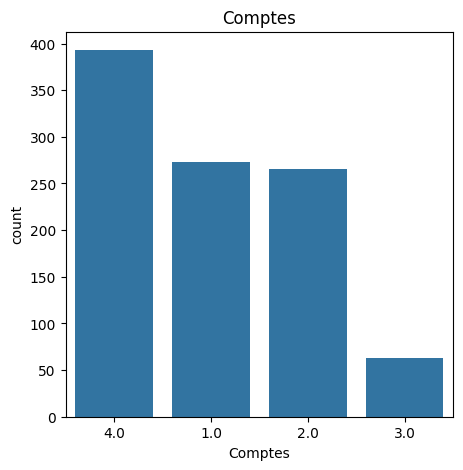

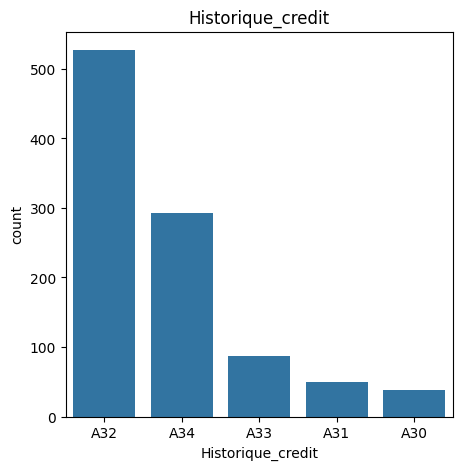

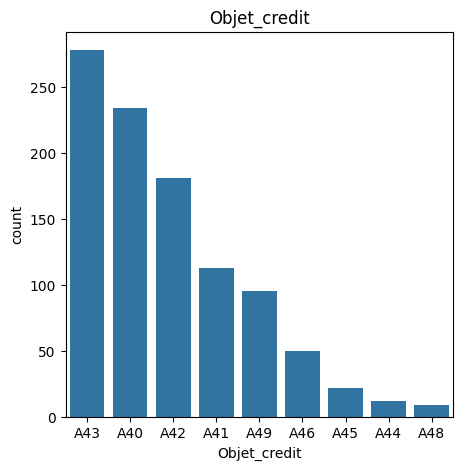

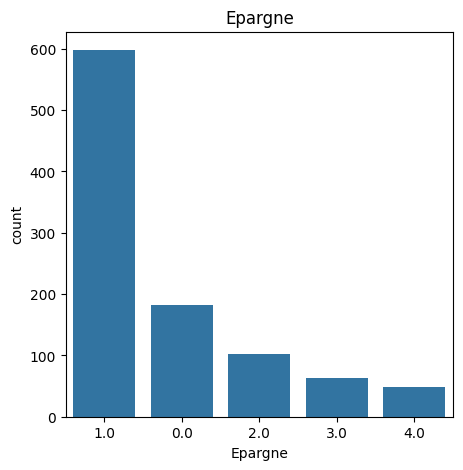

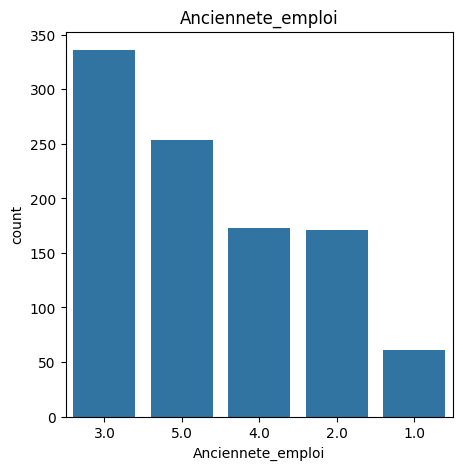

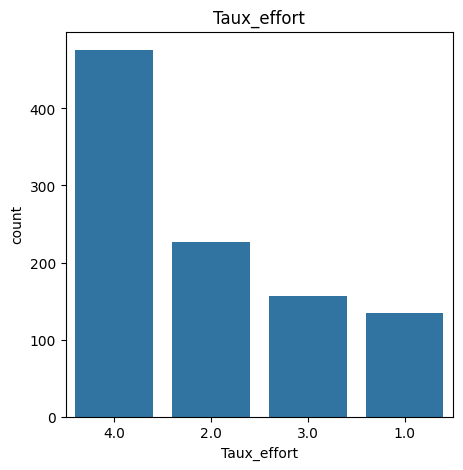

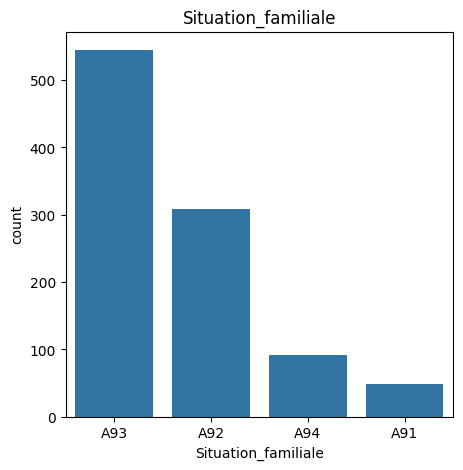

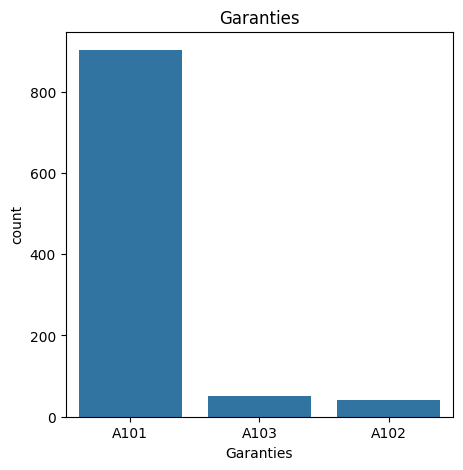

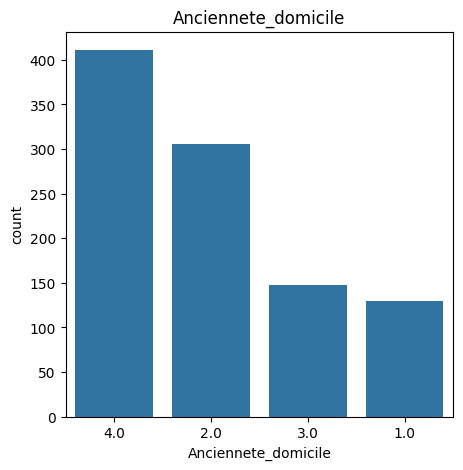

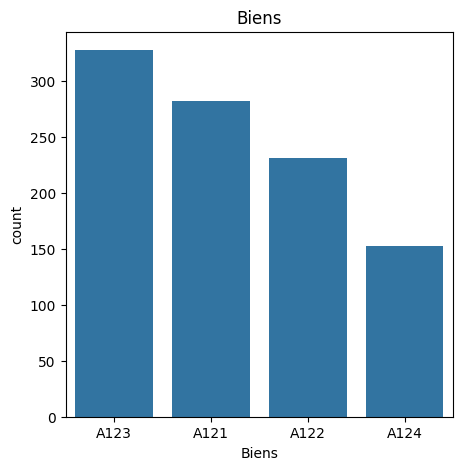

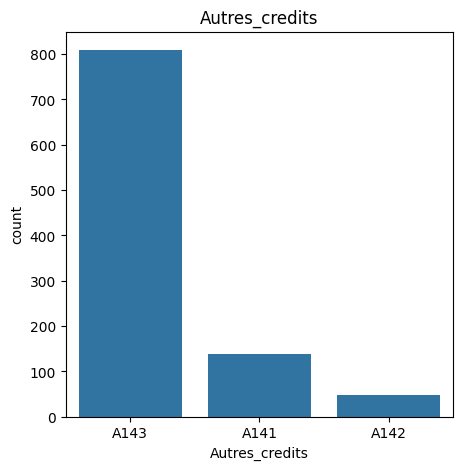

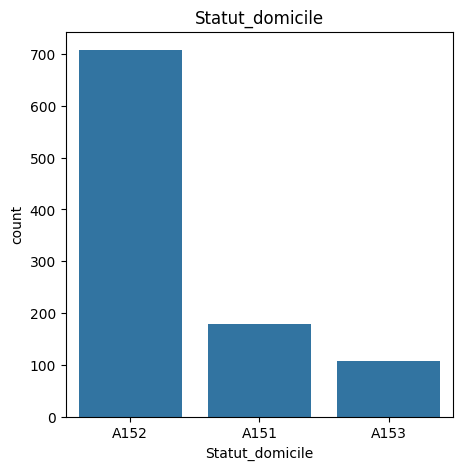

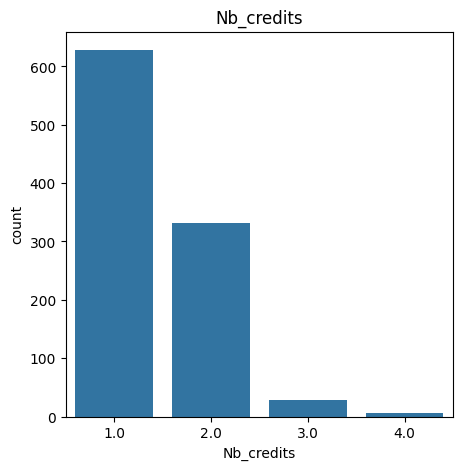

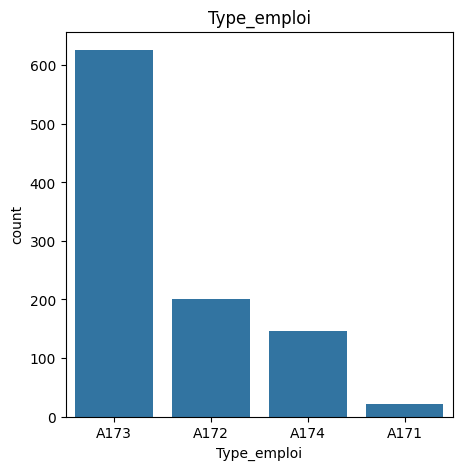

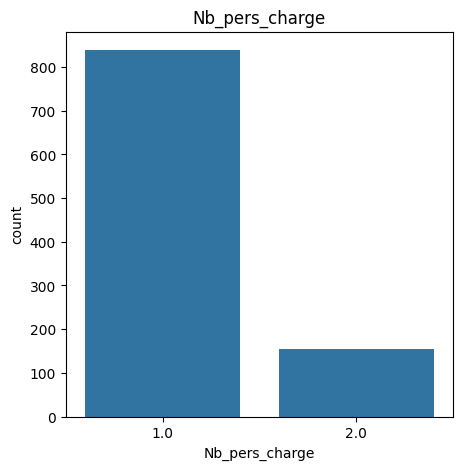

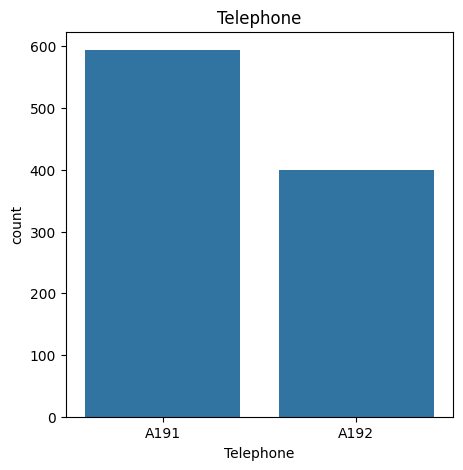

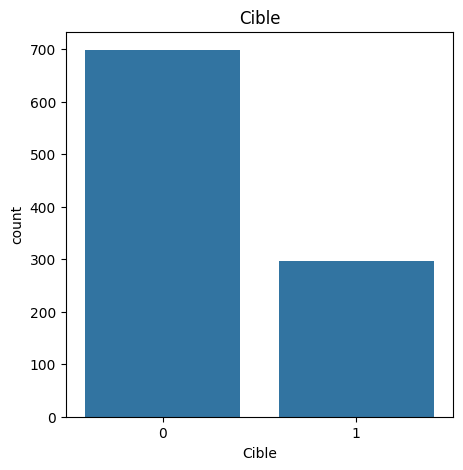

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution numérique
df[num_cols].hist(bins=20, figsize=(5,5))
plt.show()

# Distribution catégorielle (bar plot pour chaque variable catégorielle)
for col in cat_cols:
    plt.figure(figsize=(5,5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(col)
    plt.show()


In [67]:
#Matrice corrélation
#Sous ensemble des variables num
numeric_cols = ['Age', 'Duree_credit', 'Montant_credit']
corr = df[numeric_cols].corr()
print(corr) #Il faudra créer une variable (variable croisée) pour regrouper Duree_credit  et Montant_credit  corrélation >0.40

                     Age  Duree_credit  Montant_credit
Age             1.000000     -0.031622        0.036083
Duree_credit   -0.031622      1.000000        0.615537
Montant_credit  0.036083      0.615537        1.000000


In [68]:
#Création de la variable Credit_ratio
df['Credit_ratio'] = df['Montant_credit'] / df['Duree_credit']

In [69]:
#Séparer notre jeu train et test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Cible'])
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (795, 22), Test shape: (199, 22)


In [70]:
#Regarder si c'est bien réparti

In [71]:
#Cost classing de nos variables quantitatives sur le jeu train
from sklearn.preprocessing import KBinsDiscretizer
numeric_cols2 = ['Age', 'Credit_ratio']
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
train_df[numeric_cols2] = kbins.fit_transform(train_df[numeric_cols2])
print(train_df[numeric_cols2].head())

     Age  Credit_ratio
719  2.0           4.0
19   2.0           2.0
999  1.0           1.0
446  2.0           0.0
928  4.0           0.0


c:\Users\Djayan\Desktop\projet_scoring\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [72]:
import numpy as np

def psi(expected, actual):
    """Calcul PSI entre deux distributions"""
    expected = np.array(expected)
    actual = np.array(actual)
    # éviter division par zéro
    expected = np.where(expected == 0, 0.0001, expected)
    actual = np.where(actual == 0, 0.0001, actual)
    return np.sum((expected - actual) * np.log(expected / actual))


In [73]:
# Fraction 50/50 pour simuler "ancienne" et "nouvelle" population
train_old = train_df.sample(frac=0.5, random_state=42)
train_new = train_df.drop(train_old.index)


In [74]:
for col in numeric_cols2:
    dist_old = train_old[col].value_counts(normalize=True).sort_index()
    dist_new = train_new[col].value_counts(normalize=True).sort_index()
    psi_val = psi(dist_old, dist_new)
    
    # Interprétation
    if psi_val < 0.1:
        status = "stable"
    elif psi_val < 0.25:
        status = "modérément instable"
    else:
        status = "instable"
    
    print(f"{col} PSI = {psi_val:.4f} → {status}")

Age PSI = 0.0475 → stable
Credit_ratio PSI = 0.0250 → stable


In [75]:
#Mettre Credit_ratio et Age en category
train_df['Credit_ratio'] = train_df['Credit_ratio'].astype('category')
train_df['Age'] = train_df['Age'].astype('category')

# V de Cramer

In [76]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Fonction pour calculer Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calcul uniquement pour les colonnes de type 'category'
cramers_v_values = {}
for col in train_df.select_dtypes(include=['category']).columns:
    if col != 'Cible':
        cramers_v_values[col] = cramers_v(train_df[col], train_df['Cible'])

# Tri décroissant
cramers_v_values_sorted = dict(sorted(cramers_v_values.items(), key=lambda item: item[1], reverse=True))

cramers_v_values_sorted


C:\Users\Djayan\AppData\Local\Temp\ipykernel_11060\1596177669.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


{'Cle': np.float64(nan),
 'Comptes': np.float64(0.3397812605314372),
 'Historique_credit': np.float64(0.23476275212875808),
 'Epargne': np.float64(0.18166273672927719),
 'Biens': np.float64(0.1589774758526436),
 'Anciennete_emploi': np.float64(0.1475558897965531),
 'Statut_domicile': np.float64(0.14629567978157773),
 'Objet_credit': np.float64(0.14220558494266736),
 'Age': np.float64(0.1252202347014112),
 'Autres_credits': np.float64(0.11685361891861072),
 'Credit_ratio': np.float64(0.08524456856357378),
 'Situation_familiale': np.float64(0.08395794938108113),
 'Taux_effort': np.float64(0.08327848526499805),
 'Garanties': np.float64(0.07663809454976651),
 'Type_emploi': np.float64(0.035256474831436596),
 'Anciennete_domicile': np.float64(0.0),
 'Nb_credits': np.float64(0.0),
 'Nb_pers_charge': np.float64(0.0),
 'Telephone': np.float64(0.0)}

In [77]:
# Supprimer les variables sans association significative (<0.1)
import math

# Supprimer la variable 'Cle' et les valeurs infinies
cramers_v_filtered = {k: v for k, v in cramers_v_values.items() if k != 'Cle' and not math.isinf(v)}

# Trier par ordre décroissant et ne garder que les 12 premières
cramers_v_values_sorted = dict(
    sorted(cramers_v_filtered.items(), key=lambda item: item[1], reverse=True)[:12]
)

cramers_v_values_sorted



{'Comptes': np.float64(0.3397812605314372),
 'Historique_credit': np.float64(0.23476275212875808),
 'Epargne': np.float64(0.18166273672927719),
 'Biens': np.float64(0.1589774758526436),
 'Anciennete_emploi': np.float64(0.1475558897965531),
 'Statut_domicile': np.float64(0.14629567978157773),
 'Objet_credit': np.float64(0.14220558494266736),
 'Age': np.float64(0.1252202347014112),
 'Autres_credits': np.float64(0.11685361891861072),
 'Credit_ratio': np.float64(0.08524456856357378),
 'Situation_familiale': np.float64(0.08395794938108113),
 'Taux_effort': np.float64(0.08327848526499805)}

# IV

In [78]:
import pandas as pd
import numpy as np

# Fonction pour calculer WoE et IV d'une colonne
def woe_iv(df, feature, target):
    lst = []
    for val in df[feature].unique():
        total = df[df[feature] == val].shape[0]
        good = df[(df[feature] == val) & (df[target] == 0)].shape[0]
        bad = df[(df[feature] == val) & (df[target] == 1)].shape[0]
        dist_good = good / df[df[target] == 0].shape[0] if df[df[target] == 0].shape[0] != 0 else 0
        dist_bad = bad / df[df[target] == 1].shape[0] if df[df[target] == 1].shape[0] != 0 else 0
        woe = np.log((dist_good + 0.0001) / (dist_bad + 0.0001))  # éviter div par zéro
        iv = (dist_good - dist_bad) * woe
        lst.append({'Value': val, 'WoE': woe, 'IV': iv})
    df_woe = pd.DataFrame(lst)
    iv_total = df_woe['IV'].sum()
    return iv_total

# Calcul de l'IV pour toutes les colonnes catégorielles sauf la cible
iv_values = {}
for col in train_df.select_dtypes(include=['category']).columns:
    if col not in ['Cible','Cle']:
        iv_values[col] = woe_iv(train_df, col, 'Cible')

# Tri décroissant
iv_values_sorted = dict(sorted(iv_values.items(), key=lambda item: item[1], reverse=True))

iv_values_sorted


{'Comptes': np.float64(0.6186640030327939),
 'Historique_credit': np.float64(0.2847162654993659),
 'Epargne': np.float64(0.22102094992292115),
 'Objet_credit': np.float64(0.16642733645109792),
 'Biens': np.float64(0.13866136455442046),
 'Anciennete_emploi': np.float64(0.1258165328021467),
 'Statut_domicile': np.float64(0.10958973392666387),
 'Age': np.float64(0.09415683217794577),
 'Autres_credits': np.float64(0.07194971944437945),
 'Credit_ratio': np.float64(0.05717898897617817),
 'Taux_effort': np.float64(0.052807124544851494),
 'Situation_familiale': np.float64(0.05209081889146636),
 'Garanties': np.float64(0.037652794475531604),
 'Type_emploi': np.float64(0.02470114576951235),
 'Nb_credits': np.float64(0.01644911036733475),
 'Anciennete_domicile': np.float64(0.009849316716830803),
 'Telephone': np.float64(0.0033239706374715793),
 'Nb_pers_charge': np.float64(0.0005264642648369815)}

In [79]:
# Supprimer les variables sans association significative (<0.1)
import math

# Supprimer la variable 'Cle' et les valeurs infinies
iv_filtered = {k: v for k, v in iv_values.items() if k != 'Cle' and not math.isinf(v)}

# Trier par ordre décroissant et ne garder que les 12 premières
iv_values_sorted = dict(
    sorted(iv_filtered.items(), key=lambda item: item[1], reverse=True)[:12]
)

iv_values_sorted


{'Comptes': np.float64(0.6186640030327939),
 'Historique_credit': np.float64(0.2847162654993659),
 'Epargne': np.float64(0.22102094992292115),
 'Objet_credit': np.float64(0.16642733645109792),
 'Biens': np.float64(0.13866136455442046),
 'Anciennete_emploi': np.float64(0.1258165328021467),
 'Statut_domicile': np.float64(0.10958973392666387),
 'Age': np.float64(0.09415683217794577),
 'Autres_credits': np.float64(0.07194971944437945),
 'Credit_ratio': np.float64(0.05717898897617817),
 'Taux_effort': np.float64(0.052807124544851494),
 'Situation_familiale': np.float64(0.05209081889146636)}

In [ ]:
import pandas as pd

# Liste des variables que tu veux garder
selected_cols = [
    'Comptes', 'Historique_credit', 'Epargne', 'Objet_credit', 'Biens',
    'Anciennete_emploi', 'Statut_domicile', 'Age', 'Autres_credits',
    'Credit_ratio', 'Taux_effort', 'Situation_familiale', 'Cible', 'Cle'
]

# Créer le nouveau DataFrame df2
df2 = train_df[selected_cols].copy()

# Vérifier
print(df2.head())
print(df2.shape)

    Comptes Historique_credit Epargne Objet_credit Biens Anciennete_emploi  \
719     2.0               A30     2.0          A41  A123               5.0   
19      4.0               A32     3.0          A43  A123               5.0   
999     2.0               A34     2.0          A41  A123               1.0   
446     1.0               A32     1.0          A40  A123               2.0   
928     4.0               A32     0.0          A43  A123               5.0   

    Statut_domicile  Age Autres_credits Credit_ratio Taux_effort  \
719            A152  2.0           A141          4.0         3.0   
19             A152  2.0           A143          2.0         3.0   
999            A152  1.0           A143          1.0         3.0   
446            A152  2.0           A143          0.0         4.0   
928            A152  4.0           A143          0.0         4.0   

    Situation_familiale Cible     Cle  
719                 A94     0   720.0  
19                  A93     0    20.0  
99

### Encoder les variables

In [ ]:
#cat_cols = [col for col in df2.columns 
#            if df2[col].dtype == "category" and col != "Cle"]

# Encodage One-Hot
#df3 = pd.get_dummies(df2, columns=cat_cols, drop_first=True)

#df3.head()


,Cle,Comptes_2.0,Comptes_3.0,Comptes_4.0,Historique_credit_A31,Historique_credit_A32,Historique_credit_A33,Historique_credit_A34,Epargne_1.0,Epargne_2.0,...,Credit_ratio_2.0,Credit_ratio_3.0,Credit_ratio_4.0,Taux_effort_2.0,Taux_effort_3.0,Taux_effort_4.0,Situation_familiale_A92,Situation_familiale_A93,Situation_familiale_A94,Cible_1
719,720.0,True,False,False,False,False,False,False,False,True,...,False,False,True,False,True,False,False,False,True,False
19,20.0,False,False,True,False,True,False,False,False,False,...,True,False,False,False,True,False,False,True,False,False
999,1000.0,True,False,False,False,False,False,True,False,True,...,False,False,False,False,True,False,False,True,False,False
446,447.0,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,True,False,False,True
928,929.0,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


Pour préparer les variables qualitatives du jeu de données `df2`, nous avons retenu un encodage **One-Hot** plutôt qu’un **Label Encoding**. En effet, le Label Encoding attribue des valeurs numériques arbitraires aux modalités, ce qui revient à imposer un ordre entre elles. Or, non seulement plusieurs variables n’ont naturellement **aucune structure ordinale**, mais surtout nous ne disposons pas d’un **sens économique clair** permettant de déterminer si un ordre particulier serait justifié (par exemple pour les types de comptes, les situations familiales ou les statuts d’emploi). Introduire un ordre fictif reviendrait donc à injecter une information non fondée dans les modèles.

À l’inverse, le One-Hot Encoding crée une variable binaire par modalité, ce qui permet de **préserver la nature purement nominale** de ces variables sans imposer de relation de rang. Couplé avec l’option `drop_first = TRUE`, il évite également les problèmes de multicolinéarité. Ce choix est ainsi mieux adapté au contexte économique du projet et assure une représentation fidèle et exploitable des variables catégorielles pour l’ensemble des modèles utilisés par la suite.


In [ ]:
%store df2